In [1]:
import logging
import os

import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
from tqdm import tqdm_notebook as tqdm

import utils
import model.net as net
from model.data_loader import DataLoader
from evaluate import evaluate, f_score_simple

In [2]:
data_dir = 'data/coNLL/eng/'
model_dir = 'experiments/coNLL/active_learning/'
# data_dir = 'data/kaggle/'
# model_dir = 'experiments/kaggle/active_learning/'
json_path = os.path.join(model_dir, 'params.json')
params = utils.Params(json_path)
# use GPU if available
params.cuda = torch.cuda.is_available()

In [3]:
# load data
data_loader = DataLoader(data_dir, params)
data = data_loader.load_data(['train', 'val', 'test'])
train_data = data['train']
val_data = data['val']
test_data = data['test']

# specify the train and val dataset sizes
params.train_size = train_data['size']
params.val_size = val_data['size']
params.test_size = test_data['size']

params.pad_tag_ind = data_loader.tag_map[params.pad_tag]

14041 14041
3250 3250
3453 3453


In [4]:
# Define the model and optimizer
model = net.Net(params).cuda()

In [27]:
# optimizer = optim.SGD(model.parameters(), lr=params.learning_rate, momentum=0.9) # nesterov=True
# optimizer = optim.RMSprop(model.parameters(), lr=params.learning_rate)
# optimizer = optim.Rprop(model.parameters(), lr=params.learning_rate)
# fetch loss function and metrics
loss_fn = net.loss_fn
metrics = net.metrics

In [135]:
def model_init():
    global model, optimizer, loss_fn, metrics
    
    model = net.Net(params).cuda()
    # optimizer = optim.SGD(model.parameters(), lr=params.learning_rate, momentum=0.9) # nesterov=True
    optimizer = optim.Adam(model.parameters(), lr=params.learning_rate)
    # fetch loss function and metrics
    loss_fn = net.loss_fn
    metrics = net.metrics
    
    # Set the logger
    utils.set_logger(os.path.join(model_dir, 'train.log'))
    
def save_model(save_file='init'):
    filepath = os.path.join(model_dir, save_file + '.pth.tar')
    if not os.path.exists(model_dir):
        print("Model Directory does not exist! Making directory {}".format(checkpoint))
        os.mkdir(model_dir)
    else:
        # print("Model Directory exists! ")
        print('Model saved')
        
    state = {'state_dict': model.state_dict(), 'optim_dict' : optimizer.state_dict()}    
    torch.save(state, filepath)


def restore_model(restore_file='init'):
    global optimizer
    
    checkpoint = os.path.join(model_dir, restore_file + '.pth.tar')
    if not os.path.exists(checkpoint):
        raise Exception("File doesn't exist {}".format(checkpoint))
    checkpoint = torch.load(checkpoint)
    model.load_state_dict(checkpoint['state_dict'])
    print('Model Restored')
    
    # can change the optimizer here
    # optimizer = optim.RMSprop(model.parameters(), lr=params.learning_rate * 0.1)
    # optimizer = optim.SGD(model.parameters(), lr=params.learning_rate * 0.15, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=params.learning_rate * 0.1)

In [108]:
def train(model, optimizer, loss_fn, data_iterator, metrics, params, num_steps):
    """Train the model on `num_steps` batches
    Args:
        model: (torch.nn.Module) the neural network
        optimizer: (torch.optim) optimizer for parameters of model
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        data_iterator: (generator) a generator that generates batches of data and labels and sequence lenghts in batch
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
        num_steps: (int) number of batches to train on, each of size params.batch_size
    """

    # set model to training mode
    model.train()

    # summary for current training loop and a running average object for loss
    summ = []
    loss_avg = utils.RunningAverage()
    
    # Use tqdm for progress bar
    t = trange(num_steps) 
    for i in t:
        # fetch the next training batch
        train_batch, labels_batch,_ = next(data_iterator)

        # compute model output and loss
        output_batch = model(train_batch)
        loss = loss_fn(output_batch, labels_batch)

        # clear previous gradients, compute gradients of all variables wrt loss
        optimizer.zero_grad()
        loss.backward()

        # performs updates using calculated gradients
        optimizer.step()

        # update the average loss
        loss_avg.update(loss.item())
        t.set_postfix(loss='{:05.3f}'.format(loss_avg()))

    # compute sample metrics on the last batch of the epoch
    # extract data from torch Variable, move to cpu, convert to numpy arrays
    output_batch = output_batch.data.cpu().numpy()
    labels_batch = labels_batch.data.cpu().numpy()

    # compute all metrics on this batch
    summary_batch = {metric:metrics[metric](output_batch, labels_batch, params) for metric in metrics}
    summary_batch['loss'] = loss.item()
    summ.append(summary_batch)
    
    metrics_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]} 
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())
    logging.info("- Train metrics: " + metrics_string)

In [109]:
def train_model(data, labels, step=None):
    '''step may indicate acuistion iteration and can be used for logging'''
    print('Training data size: ' + str(len(data)))
    
    data_dict = {'data':data, 'labels':labels, 'size':len(data)} 
    num_steps = (len(data) + 1) // model.params.batch_size
    
    for epoch in range(model.params.num_epochs):
        # run one epoch
        logging.info("Epoch {}/{}".format(epoch + 1, model.params.num_epochs))
        data_iterator = data_loader.data_iterator(data_dict, model.params, shuffle=True)
        train(model, optimizer, loss_fn, data_iterator, metrics, model.params, num_steps)

In [110]:
def test_model(data, labels, step=None):
    # Evaluate for one epoch on validation set
    # set on eval mode
    model.eval()
    
    num_steps = (len(data) + 1) // model.params.batch_size
    data_dict = {'data':data, 'labels':labels, 'size':len(data)} 
    
    # data_iterator = data_loader.data_iterator(data_dict, model.params, shuffle=False)
    test_metrics = evaluate(model, loss_fn, data_dict, metrics, data_loader, params, num_steps)
    
    # val_acc = val_metrics['accuracy']
    test_acc = test_metrics['f1']
    return test_acc

In [111]:
def mnlp(pool_data, num_samples, step=None):
    # set in test mode
    model.eval()
    
    data_dict = {'data':pool_data, 'labels':[1]*len(pool_data), 'size':len(pool_data)}
    data_iterator = data_loader.data_iterator(data_dict, model.params, shuffle=False)
    
    num_steps = (len(pool_data) + 1) // model.params.batch_size
    
    print('MNLP over Pool Data')
    probs = np.array([])
    # Use tqdm for progress bar
    t = trange(num_steps) 
    for i in t:
        # fetch the next training batch
        data_batch, labels_batch, seql = next(data_iterator)
        # compute model output and loss
        output_batch = model(data_batch)
        output_batch = output_batch.data.cpu().numpy()
        
        outputs = np.max(output_batch, axis=1) # shape: seql*batch_size
        outputs = outputs.reshape((len(labels_batch), -1))
        assert len(seql) == len(outputs), 'lengths of seql and outputs should match'
        # mask beyond sequence length to 0
        for i in range(len(outputs)):
            outputs[i][seql[i]:] = 0
        
        p = np.sum(outputs, axis=1) / seql
        probs = np.hstack((probs, p))
    
    pos = np.argpartition(probs, num_samples)[:num_samples]
    return pos

In [115]:
def var_ratio(pool_data, num_samples, step=None):
    # set in test mode
    model.eval()
    
    data_dict = {'data':pool_data, 'labels':[1]*len(pool_data), 'size':len(pool_data)}
    data_iterator = data_loader.data_iterator(data_dict, model.params, shuffle=False)
    
    num_steps = (len(pool_data) + 1) // model.params.batch_size
    
    print('MNLP over Pool Data')
    probs = np.array([])
    # Use tqdm for progress bar
    t = trange(num_steps) 
    for i in t:
        # fetch the next training batch
        data_batch, labels_batch, seql = next(data_iterator)
        # compute model output and loss
        output_batch = model(data_batch)
        output_batch = output_batch.data.cpu().numpy()
        
        outputs = np.max(output_batch, axis=1) # shape: seql*batch_size
        outputs = outputs.reshape((len(labels_batch), -1))
        assert len(seql) == len(outputs), 'lengths of seql and outputs should match'
        # mask beyond sequence length to 0
        for i in range(len(outputs)):
            outputs[i][seql[i]:] = 0
        
        p = np.sum(outputs, axis=1)
        probs = np.hstack((probs, p))
    
    pos = np.argpartition(probs, num_samples)[:num_samples]
    return pos

In [137]:
a = ActiveLearner(train_data['data'], train_data['labels'], test_data['data'], test_data['labels'], 
                  model_init, train_model, test_model, save_model, restore_model, init_num_samples=200)

Epoch 1/15
 50%|█████     | 20/40 [00:00<00:00, 103.18it/s, loss=1.452]

Picked 200 datapoints
Size of updated unsupervised pool = 13841

Initial Training
Training data size: 200


100%|██████████| 40/40 [00:00<00:00, 194.18it/s, loss=1.423]
- Train metrics: accuracy: 0.727 ; loss: 1.149
Epoch 2/15
100%|██████████| 40/40 [00:00<00:00, 202.20it/s, loss=0.715]
- Train metrics: accuracy: 0.810 ; loss: 0.787
Epoch 3/15
100%|██████████| 40/40 [00:00<00:00, 202.97it/s, loss=0.675]
- Train metrics: accuracy: 0.560 ; loss: 1.436
Epoch 4/15
100%|██████████| 40/40 [00:00<00:00, 201.29it/s, loss=0.625]
- Train metrics: accuracy: 0.903 ; loss: 0.505
Epoch 5/15
100%|██████████| 40/40 [00:00<00:00, 200.40it/s, loss=0.578]
- Train metrics: accuracy: 0.857 ; loss: 0.516
Epoch 6/15
100%|██████████| 40/40 [00:00<00:00, 202.12it/s, loss=0.565]
- Train metrics: accuracy: 0.915 ; loss: 0.477
Epoch 7/15
100%|██████████| 40/40 [00:00<00:00, 202.38it/s, loss=0.526]
- Train metrics: accuracy: 0.864 ; loss: 0.486
Epoch 8/15
100%|██████████| 40/40 [00:00<00:00, 201.04it/s, loss=0.475]
- Train metrics: accuracy: 0.843 ; loss: 0.600
Epoch 9/15
100%|██████████| 40/40 [00:00<00:00, 201.19it/s,

Model saved
Successfully saved the initial model


In [ ]:
a.run(10, [mnlp, random_acq], pool_subset_count=1000, num_samples=10)

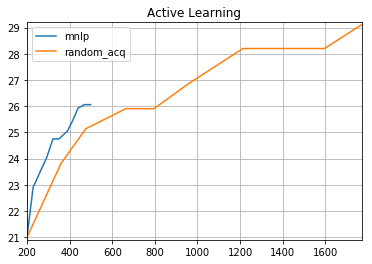

In [141]:
a.plot()

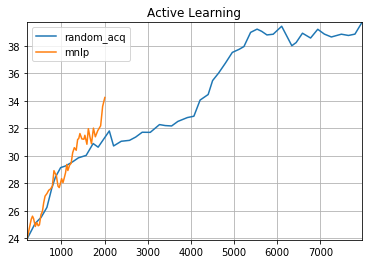

In [106]:
a.plot()

In [98]:
y_random[0]

array([ 200.,  410.,  528.,  649.,  774.,  979., 1152., 1308., 1519.,
       1670., 1807., 1956., 2189., 2292., 2422., 2552., 2683., 2853.,
       3014., 3203., 3347.])

In [100]:
y_mnlp[0]

array([ 200.,  219.,  255.,  289.,  317.,  351.,  391.,  421.,  449.,
        482.,  515.,  542.,  577.,  612.,  645.,  677.,  707.,  736.,
        765.,  788.,  825.,  849.,  890.,  920.,  954.,  999., 1034.,
       1062., 1090., 1129., 1168., 1207., 1245., 1289., 1318., 1351.,
       1384., 1425., 1456., 1479., 1502., 1531., 1563., 1603., 1634.,
       1675., 1712., 1731., 1779., 1805., 1836.])

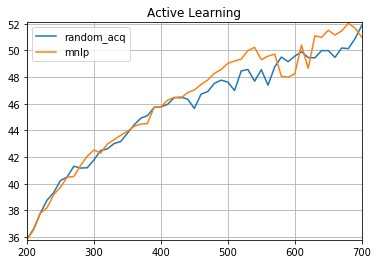

In [21]:
a.plot()

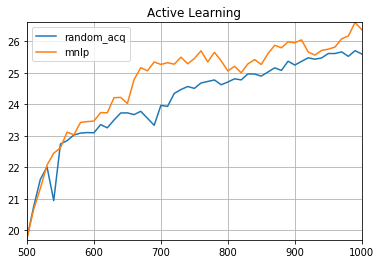

In [14]:
a.plot()

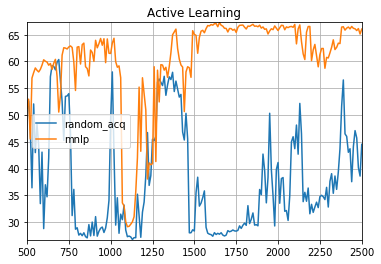

In [15]:
a.plot()

## Analyse the acquired sentences

In [54]:
def print_sent(sentence):
    s = []
    for word in sentence:
        s += [data_loader.idx_vocab[word]]
    
    print(' '.join(s))
    
def print_labels(tags):
    s = []
    for tag in tags:
        s += [data_loader.idx_tag[tag]]
    
    print(' '.join(s))

In [36]:
pool_subset_random_index = np.random.choice(range(len(a.pool_data)), 1000, replace=False)
X_pool_subset = [a.pool_data[i] for i in pool_subset_random_index]
y_pool_subset = [a.pool_labels[i] for i in pool_subset_random_index]

In [75]:
# acquisition function returns the chosen positions in the passed list
pos = random_acq(X_pool_subset, 10) 

In [76]:
datapoints = [X_pool_subset[i] for i in pos]
labels = [y_pool_subset[i] for i in pos]

In [85]:
print_sent(datapoints[4])

Lebed , who met Russian Prime Minister Viktor Chernomyrdin on Monday to discuss the progress he made on a political settlement for the breakaway region , has been seeking a meeting with President Boris Yeltsin , who started a holiday near Moscow on Monday .


In [86]:
print_labels(labels[4])

I-PER O O O I-MISC O O I-PER I-PER O O O O O O O O O O O O O O O O O O O O O O O O I-PER I-PER O O O O O O I-LOC O O O


In [131]:
def random_acq(pool_data, num_samples, step=None):
    # return np.random.rand(len(pool_data)) 
    return np.random.choice(len(pool_data), num_samples, replace=False)


class ActiveLearner(object):
    '''Performs active learning'''
    
    def __init__(self, pool_data, pool_labels, test_data, test_labels, 
                 clear_model_fn, train_fn, eval_fn, 
                 save_model, recover_model,
                 init_num_samples=100):
        '''init_num_samples denote how many datapoints to be samples initially, 
        num_smaples denote how many datapoints to be samples at each iteration'''
        
        # train data is python lists not numpy arrays
        # so as to allow datapoints of different lengths like sentences
        # list() expression also takes a deep copy
        self.pool_data = list(pool_data)
        self.pool_labels = list(pool_labels)
        self.test_data = list(test_data)
        self.test_labels = list(test_labels)
        assert (len(self.pool_data)==len(self.pool_labels) and 
               len(self.test_data)==len(self.test_labels)), "data and labels size don't match"
        
        
        self.init_num_samples = init_num_samples
        self.train_fn = train_fn
        self.eval_fn = eval_fn
        
        self.experiment_no = 1 
        
        
        if (self.init_num_samples > len(pool_data)):
            raise Exception('Can not pick more samples than what is available in the pool data')
        
        # initialize empty arrays of dimension (0, 28, 28, 1) etc.
        # self.train_data = np.empty((0,) + self.pool_data.shape[1:])
        # self.train_labels = np.empty((0,) + self.pool_labels.shape[1:])
        self.train_data, self.train_labels = [], []
        
        self._accuracy = []
        self._x_axis = []
        self.acquisition_fn = None
        
        # initial training. 
        # But make sure that the model is cleared of previous training
        clear_model_fn()
        self._init_pick()
        print ('Initial Training')
        self.train_fn(self.train_data, self.train_labels)
        # evaluate the accuracy after initial training
        self._accuracy.append(self.eval_fn(self.test_data, self.test_labels, step=len(self.train_data)))
        self._x_axis.append(len(self.train_data)) # this is over written later and hence useless here!
        
        # Compute summaries over the pool_data
        # compute_pool_data_summary(self.pool_data)
        
        # save model function can be writing the learned model to the disk
        # or even taking a deep copy (in RAM)
        self.save_model = save_model
        self.save_model()
        print ('Successfully saved the initial model')
        # we will recover the saved model in case of multiple runs
        self.recover_model = recover_model
    
    def _init_pick(self):
        '''Pick init_number_samples of datapoints from the unsupervised data pool
        for initial training of the model.
        Remove them from the pool and return the data.
        Returns chosen datapoints and the updated pool_data'''

        # np.random.seed(0)
        indices = np.random.choice(range(len(self.pool_data)), self.init_num_samples, replace=False)
        datapoints = [self.pool_data[i] for i in indices] # sadly multi-indexing works in numpy but not in lists
        labels = [self.pool_labels[i] for i in indices]
        # self.pool_data = np.delete(self.pool_data, indices, axis=0)
        # self.pool_labels = np.delete(self.pool_labels, indices, axis=0)
        self._delete_list_indices(self.pool_data, indices)
        self._delete_list_indices(self.pool_labels, indices)
        
        print("Picked " + str(self.init_num_samples) + " datapoints\nSize of updated unsupervised pool = " +
              str(len(self.pool_data)) + "\n")
        
        if (len(self.train_data) > 0):
            raise Exception('In _init_pick: The train data is not empty.')
            
        # self.train_data = np.vstack((self.train_data, datapoints))
        # self.train_labels = np.vstack((self.train_labels, labels))
        self.train_data += list(datapoints)
        self.train_labels += list(labels)
        
    
    def _delete_list_indices(self, l, ind):
        for i in sorted(ind, reverse=True):
            del l[i]
        # In-place delete, so no need to return    
        # return l

    def _active_pick(self, acquisition_fn, step=None):
        """Returns the datapoints which have the highest value as per the acquisition function
        from the pool_data.
        step is an optional argument which can be used for things 
        like changing acquisition function according to iteration number
        """
        # This condition should ideally be False because we have already done the - 
        # necessary checks while initializing run() function
        if (len(self.pool_data) < self.num_samples):
            raise Exception('Fatal mistake: pool data is exhausted')
        
            
        how_many = self.pool_subset_count if self.pool_subset_count <= len(self.pool_data) else len(self.pool_data)
        pool_subset_random_index = np.random.choice(range(len(self.pool_data)), how_many, replace=False)
        X_pool_subset = [self.pool_data[i] for i in pool_subset_random_index]
        y_pool_subset = [self.pool_labels[i] for i in pool_subset_random_index]

        print('Search over Pool of Unlabeled Data size = '+ str(len(X_pool_subset)))

        # acquisition function returns the chosen positions in the passed list
        pos = acquisition_fn(X_pool_subset, self.num_samples, step) 
    
        datapoints = [X_pool_subset[i] for i in pos]
        labels = [y_pool_subset[i] for i in pos]
        
        # print pool_subset_random_index[:10]
        # self.pool_data = np.delete(self.pool_data, (pool_subset_random_index[pos]), axis=0)
        # self.pool_labels = np.delete(self.pool_labels, (pool_subset_random_index[pos]), axis=0)
        indices = [pool_subset_random_index[i] for i in pos]
        self._delete_list_indices(self.pool_data, indices)
        self._delete_list_indices(self.pool_labels, indices)
        
        print("\nPicked " + str(self.num_samples) + " datapoints\nSize of updated Unsupervised pool = " + 
              str(len(self.pool_data)))

        # self.train_data = np.vstack((self.train_data, datapoints))
        # self.train_labels = np.vstack((self.train_labels, labels))
        self.train_data += list(datapoints)
        self.train_labels += list(labels)

        # return len(pos)
        
        ## written for NER only
        num_words = sum([len(s) for s in datapoints])
        return num_words
    
    
    def run(self, n_iter, acquisition_fn, num_samples=10, pool_subset_count = None):
        '''Run active learning for given number of iterations.
        The acquisition_fn is(are) the name of the function(s) which computes acquisition values.
        aquisition_fn can be a list of function references as well - which is called a multi_run.
        '''
        
        self.num_samples = num_samples # required in _active_pick
        
        if ((pool_subset_count is None) or (pool_subset_count > len(self.pool_data))):
            self.pool_subset_count = pool_subset_count = len(self.pool_data)
        else:
            self.pool_subset_count = pool_subset_count 
        
        if (pool_subset_count < self.num_samples):
            raise Exception("pool subset count can't be smaller than num_samples")
            
        if (n_iter * self.num_samples > len(self.pool_data)):
            raise Exception('Pool data is small.\nReduce the number of iterations or number of samples to pick')
         
        if (type(acquisition_fn) is not list):    
            # if type of aq function is not list then make it a list
            acquisition_fn = [acquisition_fn]   
    
        self.acquisition_fn = acquisition_fn
        
        # self._x_axis = range(self.init_num_samples, self.init_num_samples + self.num_samples*(n_iter+1), self.num_samples)
        self._x_axis = np.zeros((len(acquisition_fn), n_iter+1))
        # initialize _accuracy matrix (2d array)
        self._accuracy = np.zeros((len(acquisition_fn), n_iter+1))

        for i_aq in range(len(acquisition_fn)):
            # recover the model
            self._recover_model_and_data()

            # Do the testing with initial data
            # We could have saved that value, but it is a good check if the model is properly recovered or not
            self._accuracy[i_aq, 0] = self.eval_fn(self.test_data, self.test_labels)
            self._x_axis[i_aq][0] = self.init_num_samples

            for i in range(n_iter):
                print('\nExperiment ' + str(self.experiment_no) + ' Aquisition function: ' + 
                      str(acquisition_fn[i_aq].__name__) + ': ')
                print('ACQUISITION ITERATION ' + str(i+1) + ' of ' + str(n_iter))
                num = self._active_pick(acquisition_fn[i_aq], step=i)
                # if active_pick doesn't return even a single datapoint, stop
                if (num == 0):
                    break
                
                # allowing non fixed number of samples to be returned from active_pick
                # won't be suitable for running multiple experiments, but it will 
                # record only the last _x_axis
                self._x_axis[i_aq][i+1] = self._x_axis[i_aq][i] + num
                
                self.train_fn(self.train_data, self.train_labels)
                # self._accuracy[i_aq, i+1] = self.eval_fn(self.test_data, self.test_labels, step=len(self.train_data))
                acc = self.eval_fn(self.test_data, self.test_labels, step=len(self.train_data))
                if acc < self._accuracy[i_aq][i]:
                    # need to restore model
                    name = 'best'
                    if i == 0:
                        name = 'init'
                    
                    self.recover_model(name)
                    acc = self._accuracy[i_aq][i]
                    
                if acc > self._accuracy[i_aq][i]:
                    self.save_model('best')
                
                self._accuracy[i_aq][i+1] = acc
                # assert self._x_axis[i+1] == len(self.train_data)

                # Compute summaries over the pool_data
                # compute_pool_data_summary(self.pool_data, step=len(self.train_data))
        
        return self._x_axis, self._accuracy 
    
    
    
    def _recover_model_and_data(self):
        self.recover_model()
        print ('Recovered Saved Model')
        
        # reset pool_data to the whole data except initial data
        # self.pool_data = np.vstack((self.pool_data, self.train_data[self.init_num_samples:]))
        # self.pool_labels = np.vstack((self.pool_labels, self.train_labels[self.init_num_samples:]))
        self.pool_data += self.train_data[self.init_num_samples:]
        self.pool_labels += self.train_labels[self.init_num_samples:]
        
        # set train data to initially picked data only
        # self.train_data = np.delete(self.train_data, range(self.init_num_samples, len(self.train_data)), axis=0)
        # self.train_labels = np.delete(self.train_labels, range(self.init_num_samples, len(self.train_labels)), axis=0)
        self.train_data = self.train_data[:self.init_num_samples]
        self.train_labels = self.train_labels[:self.init_num_samples]

        
    
    def plot(self, x_axis=None, y_axis=None, label=None, title='Active Learning', loc=0):
        '''Plot the accuracy'''
        %matplotlib inline
        from matplotlib import pyplot as plt
            
        if x_axis is None:
            x_axis = self._x_axis
            y_axis = np.array(self._accuracy)
        
        if len(x_axis[0]) <= 1:
            raise Exception('Please run experiment before plotting!')
        
        x_start = x_axis[0][0] # self.init_num_samples
        # x_end = x_axis[-1]
        x_end = np.max(x_axis)
        
        y_start = np.round(np.min(y_axis), 1)
        if (y_start > np.min(y_axis)):
            y_start -= 0.1
            
        # y_end = 1.0
        y_end = np.round(np.max(y_axis), 1)
        if (y_end < np.max(y_axis)):
            y_end += 0.1
        
        plt.axis([x_start, x_end, y_start, y_end])

        # no label is given or label doesn't correpond to multi run
        if label is None or len(label) != len(y_axis):
            if (self.acquisition_fn is None):
                raise Exception('Please pass the labels array as an argument')
            label = [s.__name__ for s in self.acquisition_fn]  

        for i in range(len(y_axis)):
             plt.plot(x_axis[i], y_axis[i], label=label[i])   

        
        plt.grid()
        plt.title(title)
        plt.legend(loc=loc)
        plt.show()  
        
    
    def experiment(self, n_iter, acquisition_fn, num_samples=10, pool_subset_count = None, num_exp=3):
        '''Run the experiments for the given number of times (num_exp) and 
        return average accuracy values over all experiments.'''
        
        if type(acquisition_fn) is not list:
            raise Exception('experiment is to compare different acquisition functions, hence it should be a list')
        
        # define new variables to hold averages: useful incase we want to stop experiment forcefully in between
        self._avg_accuracy = np.zeros((len(acquisition_fn), n_iter+1))
        
        for i in range(num_exp):
            self.experiment_no = i+1
            print ('\nExperiment number : ' + str(self.experiment_no) + '\n****************\n')
            self.run(n_iter, acquisition_fn, num_samples, pool_subset_count)
            self._avg_accuracy = (self._avg_accuracy * (i) + self._accuracy) / (i+1) # running average
        
        # finally assign back the avg accuracy to _accuracy variable for proper plotting
        self._accuracy = self._avg_accuracy
        
        return self._x_axis, self._accuracy 